In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys

In [197]:
experiments_df = pd.read_csv(os.path.join('data_sim', 'experiments_sim.txt'), sep=',', header=0)
display(experiments_df)

,expname,rollouts,tree,updatefreq,runs,obstacle,prunthreshold,u_bounded,inputvar,improved_version,threads,filterorder_and_window,done,refreshrate_meashured
0,1A,20,no,60.0,10,no,0,2.0,0.2,no,1,1_6,yes,200
1,1B,20,no,100.0,10,no,0,2.0,0.2,no,2,1_6,yes,200
2,2A,64,no,60.0,10,no,0,2.0,0.2,no,4,1_6,yes,200
3,2B,64,no,100.0,10,no,0,2.0,0.2,no,4,1_6,yes,100
4,3A,128,no,60.0,10,no,0,2.0,0.2,no,4,1_6,yes,200
5,3B,128,no,100.0,10,no,0,2.0,0.2,no,6,1_6,yes,130
6,11A,20,yes,0.0,10,no,0,2.0,0.2,no,2,1_6,yes,70
7,12A,26,yes,0.0,10,no,0,2.0,0.2,no,2,1_6,yes,55
8,13A,32,yes,0.0,10,no,0,2.0,0.2,no,2,1_6,yes,45
9,21B,20,no,100.0,10,yes,0,2.0,0.2,no,6,1_6,yes,150


In [199]:
class SequenceHandler():
    def __init__(self, obstacle_mode='both'):
        self.obstacle_mode = obstacle_mode
        
        
        
        self.sequence_dict = {}
        
        self.experiment_df = self.get_experiment_config()   
        
        self.columns_to_summarize = ['rmse_cost','rmse_eucledian_distance',
                                     'rmse_t_90_cost', 'rmse_t_90_eucledian_distance', 
                                     't_90_cost', 't_90_eucledian_distance']
        
        self.columns_to_summarize_naming = ['RMSE \n(cost function)','RMSE \n(eucledian distance)',
                                             'RMSE T90 \n(cost function)', 'RMSE T90 \n(eucledian distance)', 
                                             'T90 \n(cost function)', 'T90 \n(eucledian distance)']
        
        
        
        for seq in range(1,7):
            self.sequence_dict[seq] = {}
            for expname in self.experiment_df['expname']:
                self.sequence_dict[seq][expname] = {'dfs':[], 'metrics':[]}
                
                total_runs = self.experiment_df.loc[self.experiment_df['expname']==expname].iloc[0,4]

                for run in range(0, total_runs):
                    seq_df = self.read_sequence_df(expname, total_runs, run, seq)
                    seq_df = self.preprocess_df(seq_df)
                    self.sequence_dict[seq][expname]['dfs'].append(seq_df)

                    seq_metrics_df = self.get_sequence_metric_df(seq_df)
                    self.sequence_dict[seq][expname]['metrics'].append(seq_metrics_df)
                    
                self.gen_exp_seq_summary(seq, expname)
                self.gen_exp_seq_metrics(seq, expname)
                
        self.gen_summary_df()
        self.gen_short_summary_df()
                          
        
    
        
    def get_experiment_config(self):
        experiment_df = pd.read_csv(os.path.join('data_sim', 'experiments_sim.txt'), sep=',', header=0)
        
        experiment_df = experiment_df.loc[experiment_df['done']=='yes']
        
        if self.obstacle_mode == 'both':
            pass
        elif self.obstacle_mode == 'yes':
            experiment_df = experiment_df.loc[experiment_df['obstacle']=='yes']
        elif self.obstacle_mode == 'no':
            experiment_df = experiment_df.loc[experiment_df['obstacle']=='no']
        
        display(experiment_df)
        
        return experiment_df
    
    def read_sequence_df(self, expname, total_runs, run, sequence):
        return pd.read_csv(os.path.join('data_sim', expname, str(sequence), expname+'_'+str(total_runs)+'_'+str(run)+'_seq_'+str(sequence)+'_unified.csv'), sep=',', header=0)
        
        
    def get_sequence_metric_df(self, orig_df):

        df = orig_df.copy()
        
        df_metrics = pd.DataFrame(columns=self.columns_to_summarize)

        # t_90
        ## eucledian distance
        delta_x_orig = df['pos_x_DESI'].iloc[0]-df['pos_x_DESI'].iloc[1]
        delta_y_orig = df['pos_y_DESI'].iloc[0]-df['pos_y_DESI'].iloc[1]
        delta_z_orig = df['pos_z_DESI'].iloc[0]-df['pos_z_DESI'].iloc[1]

        eucledian_distance_orig = np.sqrt( delta_x_orig**2 + delta_y_orig**2 + delta_z_orig**2 )

        try:
            t_90_eucledian_distance = (df.loc[df['_eucledian_distance']>0.1*eucledian_distance_orig]).iloc[-1]['_resetted_time']
        except:
            print('set t_90_eucledian_distance to NaN')
            t_90_eucledian_distance = np.nan
        
        ## cost
        t_90_cost = (df.loc[df['cost']>0.1*df['cost'].max()]).iloc[-1]['_resetted_time']


        # RMSE
        ## eucledian distance
        rmse_eucledian_distance = df['_eucledian_distance'].mean()
        ## cost
        rmse_cost = df['cost'].mean()


        # RMSE after t_90
        ## eucledian distance
        if t_90_eucledian_distance is not np.nan:
            rmse_t_90_eucledian_distance = df.loc[df['_resetted_time'] >= t_90_eucledian_distance]['_eucledian_distance'].mean()
        else:
            print('set rmse_t_90_eucledian_distance to NaN')
            rmse_t_90_eucledian_distance = np.nan
        
        
        ## cost
        rmse_t_90_cost = df.loc[df['_resetted_time'] >= t_90_cost]['cost'].mean()
        
        # bild metrics df
        
        df_metrics.at[0, 'rmse_eucledian_distance'] = rmse_eucledian_distance
        df_metrics.at[0, 'rmse_t_90_eucledian_distance'] = rmse_t_90_eucledian_distance
        df_metrics.at[0, 't_90_eucledian_distance'] = t_90_eucledian_distance
        
        df_metrics.at[0, 'rmse_cost'] = rmse_cost
        df_metrics.at[0, 'rmse_t_90_cost'] = rmse_t_90_cost
        df_metrics.at[0, 't_90_cost'] = t_90_cost
        

        return df_metrics
    
    
    ## preprocessing helpers
    
    def preprocess_df(self, df):
        
        # add resetted time
        df['_resetted_time'] = (df['time'] - df['time'].min())*1.0E-9
        
        df.loc[:,'cost'] = df['cost'].where(df['cost']<=200)
        
        
        return df
    
    def gen_exp_seq_summary(self, seq, expname):       
        
        for run in range(0, len(self.sequence_dict[seq][expname]['metrics'])):
            if run==0:
                exp_seq_sum_df = self.sequence_dict[seq][expname]['metrics'][run].copy()
            else:
                exp_seq_sum_df = pd.concat([exp_seq_sum_df, self.sequence_dict[seq][expname]['metrics'][run]], ignore_index=True)
                
        self.sequence_dict[seq][expname]['df_sum']= exp_seq_sum_df
        
        
    def gen_exp_seq_metrics(self, seq, expname):
        
        metric_df = pd.DataFrame()
        
        for column_name in self.columns_to_summarize:
            metric_df.at[0, column_name+'_mean'] = self.sequence_dict[seq][expname]['df_sum'][column_name].mean()
            metric_df.at[0, column_name+'_median'] = self.sequence_dict[seq][expname]['df_sum'][column_name].median()
            metric_df.at[0, column_name+'_q1'] = self.sequence_dict[seq][expname]['df_sum'][column_name].quantile(q=0.25)
            metric_df.at[0, column_name+'_q3'] = self.sequence_dict[seq][expname]['df_sum'][column_name].quantile(q=0.75)
        
        self.sequence_dict[seq][expname]['df_metrics'] = metric_df
        
    
    def gen_summary_df(self):
        idx = 0
        for seq in range(1,7):
            for expname in self.experiment_df['expname']: 
                if idx==0:
                    big_summary_df = self.sequence_dict[seq][expname]['df_metrics']
                    big_summary_df.at[idx, 'sequence'] = int(seq)
                    big_summary_df.at[idx, 'expname'] = expname
                else:
                    big_summary_df = pd.concat([big_summary_df, self.sequence_dict[seq][expname]['df_metrics']], ignore_index=True, sort=False)
                    big_summary_df.at[idx, 'sequence'] = int(seq)
                    big_summary_df.at[idx, 'expname'] = expname
                    
                idx+=1
                
        big_summary_df = big_summary_df[['expname', 'sequence'] + [c for c in big_summary_df if c not in ['expname', 'sequence']]]
        
        self.big_summary_df = big_summary_df
        
    
    def gen_short_summary_df(self):
        for idx, expname in enumerate(self.experiment_df['expname']):
            if idx==0:
                short_summary_df = (self.big_summary_df.loc[self.big_summary_df['expname']==expname]).mean(axis=0).to_frame()
            else:
                short_summary_df = pd.concat([short_summary_df, (self.big_summary_df.loc[self.big_summary_df['expname']==expname]).mean(axis=0)], axis=1)
                
        short_summary_df = short_summary_df.transpose()
        
        short_summary_df['expname'] = self.experiment_df['expname'].to_list()
        
        cols = short_summary_df.columns.to_list()
        cols = cols[-1:] + cols[:-1]
        short_summary_df = short_summary_df[cols]
            
           
        self.short_summary_df = short_summary_df
                
    
    
    ## generate plots
    
    def sequences_barplot(self, avg_mode='median', cost_mode='both'):
        sequences = 6
        
        if cost_mode=='both':
            nrows = len(self.columns_to_summarize)
        else:
            nrows = int(len(self.columns_to_summarize)/2)
        
        fig1, f1_ax = plt.subplots(ncols=sequences, nrows=nrows, figsize=(15,10))
        
        if cost_mode=='both':
            columns_filtered = self.columns_to_summarize
            columns_naming_filtered = self.columns_to_summarize_naming
        elif cost_mode=='cost':
            columns_filtered = [column_name for column_name in self.columns_to_summarize if 'cost' in column_name]
            columns_naming_filtered = [column_name for column_name in self.columns_to_summarize_naming if 'cost' in column_name]
        elif cost_mode=='eucledian':
            columns_filtered = [column_name for column_name in self.columns_to_summarize if 'eucledian' in column_name]
            columns_naming_filtered = [column_name for column_name in self.columns_to_summarize_naming if 'eucledian' in column_name]
            
        
        for seq in range(1,sequences+1):
            for metric_idx, column_name in enumerate(columns_filtered):
                filtered_df = self.big_summary_df.loc[self.big_summary_df['sequence']==seq]
                f1_ax[metric_idx, seq-1].bar(filtered_df['expname'],filtered_df[column_name+'_'+avg_mode], facecolor='#1F407A',edgecolor='black')
                
                # first column
                if seq-1 == 0:
                    f1_ax[metric_idx, seq-1].set_ylabel(columns_naming_filtered[metric_idx])
                
                
                
        plt.show()
        
    def short_summary_barplot(self, avg_mode='median', cost_mode='both'):
        
#         if cost_mode=='both':
#             nrows = len(self.columns_to_summarize)
#         else:
#             nrows = int(len(self.columns_to_summarize)/2)
        
        fig1, f1_ax = plt.subplots(ncols=int(len(self.columns_to_summarize)/3), nrows=3, figsize=(8,9))
        plt.subplots_adjust(wspace=0.7)
        
        if cost_mode=='both':
            columns_filtered = self.columns_to_summarize
            columns_naming_filtered = self.columns_to_summarize_naming
        elif cost_mode=='cost':
            columns_filtered = [column_name for column_name in self.columns_to_summarize if 'cost' in column_name]
            columns_naming_filtered = [column_name for column_name in self.columns_to_summarize_naming if 'cost' in column_name]
        elif cost_mode=='eucledian':
            columns_filtered = [column_name for column_name in self.columns_to_summarize if 'eucledian' in column_name]
            columns_naming_filtered = [column_name for column_name in self.columns_to_summarize_naming if 'eucledian' in column_name]
            
        for metric_idx, column_name in enumerate(columns_filtered):
            if metric_idx%2==0:
                column_n=0
            else:
                column_n=1
            
            row_n = int(metric_idx/2)
            f1_ax[row_n, column_n].bar(self.short_summary_df['expname'],self.short_summary_df[column_name+'_'+avg_mode], facecolor='#1F407A',edgecolor='black')

            f1_ax[row_n, column_n].set_ylabel(columns_naming_filtered[metric_idx])
                
                
                
        plt.show()
                    
                    
            
        
    
    def simple_barplot(self, seq, metric):
        
        fig1, f1_ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5))
        
        print()
        
        filtered_df = self.big_summary_df.loc[self.big_summary_df['sequence']==seq]
        
        f1_ax.bar(filtered_df['expname'],filtered_df[metric])
#         f1_ax.set_ylim([filtered_df[metric].min(), filtered_df[metric].max()])
        
        plt.show()
        
        
        
#         for 
#         for columname in self.columns_to_summarize:
            
#             column_name+'_mean'] =
#             column_name+'_median']
#             column_name+'_q1'] = s
#             column_name+'_q3'] = s
    
                
        
        
        
        

In [209]:
SeqHandlerObject = SequenceHandler(obstacle_mode='no')

,expname,rollouts,tree,updatefreq,runs,obstacle,prunthreshold,u_bounded,inputvar,improved_version,threads,filterorder_and_window,done,refreshrate_meashured
0,1A,20,no,60.0,10,no,0,2.0,0.2,no,1,1_6,yes,200
1,1B,20,no,100.0,10,no,0,2.0,0.2,no,2,1_6,yes,200
2,2A,64,no,60.0,10,no,0,2.0,0.2,no,4,1_6,yes,200
3,2B,64,no,100.0,10,no,0,2.0,0.2,no,4,1_6,yes,100
4,3A,128,no,60.0,10,no,0,2.0,0.2,no,4,1_6,yes,200
5,3B,128,no,100.0,10,no,0,2.0,0.2,no,6,1_6,yes,130
6,11A,20,yes,0.0,10,no,0,2.0,0.2,no,2,1_6,yes,70
7,12A,26,yes,0.0,10,no,0,2.0,0.2,no,2,1_6,yes,55
8,13A,32,yes,0.0,10,no,0,2.0,0.2,no,2,1_6,yes,45


In [201]:
# SeqHandlerObject.simple_barplot(4, 'rmse_cost_median')
# SeqHandlerObject.simple_barplot(4, 'rmse_t_90_cost_median')
# SeqHandlerObject.simple_barplot(4, 't_90_cost_median')

In [202]:
SeqHandlerObject.short_summary_df

,expname,sequence,rmse_cost_mean,rmse_cost_median,rmse_cost_q1,rmse_cost_q3,rmse_eucledian_distance_mean,rmse_eucledian_distance_median,rmse_eucledian_distance_q1,rmse_eucledian_distance_q3,...,rmse_t_90_eucledian_distance_q1,rmse_t_90_eucledian_distance_q3,t_90_cost_mean,t_90_cost_median,t_90_cost_q1,t_90_cost_q3,t_90_eucledian_distance_mean,t_90_eucledian_distance_median,t_90_eucledian_distance_q1,t_90_eucledian_distance_q3
0,21B,3.5,4.104453,4.143235,3.740840,4.652357,0.113204,0.108296,0.098785,0.122714,...,0.015196,0.022628,1.911664,1.941661,1.737509,2.141698,2.820504,2.766635,2.349979,3.241658
0,22B,3.5,4.525379,4.400007,4.044370,4.958755,0.119667,0.114455,0.106696,0.129435,...,0.016853,0.023692,2.236649,2.175000,1.949970,2.445821,3.163313,2.974981,2.704155,3.395770
0,23B,3.5,4.899096,4.884002,4.684476,5.158254,0.124982,0.124256,0.119294,0.130705,...,0.019618,0.021445,2.468336,2.416679,2.308311,2.616668,3.453341,3.449993,3.258328,3.604183
0,31B,3.5,1.918239,1.941072,1.713005,2.070611,0.055292,0.056034,0.050098,0.059970,...,0.004254,0.005817,1.116677,1.108327,1.004152,1.191708,1.348332,1.341658,1.170852,1.475002


In [203]:
SeqHandlerObject.big_summary_df.head()

,expname,sequence,rmse_cost_mean,rmse_cost_median,rmse_cost_q1,rmse_cost_q3,rmse_eucledian_distance_mean,rmse_eucledian_distance_median,rmse_eucledian_distance_q1,rmse_eucledian_distance_q3,...,rmse_t_90_eucledian_distance_q1,rmse_t_90_eucledian_distance_q3,t_90_cost_mean,t_90_cost_median,t_90_cost_q1,t_90_cost_q3,t_90_eucledian_distance_mean,t_90_eucledian_distance_median,t_90_eucledian_distance_q1,t_90_eucledian_distance_q3
0,21B,1.0,5.188518,4.998897,4.879807,5.770632,0.129365,0.129638,0.120819,0.142330,...,0.017124,0.021891,2.210022,2.199950,2.000030,2.375179,2.460022,2.499970,2.225068,2.700053
1,22B,1.0,4.761847,4.685046,4.244594,5.200799,0.122073,0.116514,0.106165,0.133572,...,0.009273,0.024520,2.159999,2.099995,1.900045,2.374949,2.370019,2.299999,2.100074,2.574957
2,23B,1.0,4.719672,4.752299,4.636289,4.796930,0.115065,0.114893,0.113030,0.118326,...,0.010274,0.012909,2.120023,2.100046,2.100007,2.200007,2.360014,2.399989,2.300022,2.400012
3,31B,1.0,1.752891,1.862501,1.546902,1.954380,0.056877,0.060616,0.052060,0.064696,...,0.005468,0.008885,1.070002,1.149933,0.999979,1.200004,1.039999,1.050012,0.925025,1.174976
4,21B,2.0,1.615730,1.837487,1.489145,1.853518,0.093407,0.067686,0.065110,0.074319,...,0.007339,0.009455,1.353107,1.500060,1.325019,1.600009,1.823076,2.000008,1.925000,2.074968


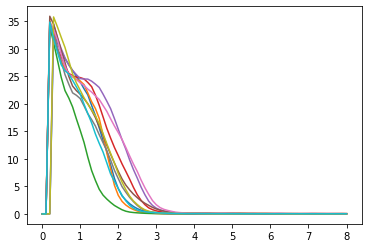

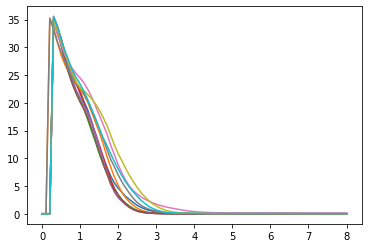

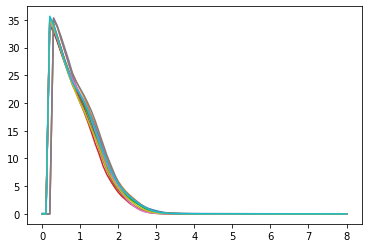

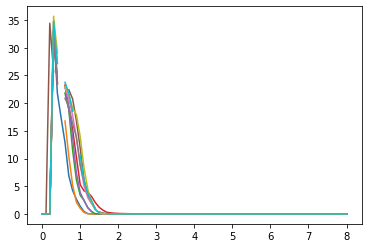

In [204]:
for expname in SeqHandlerObject.experiment_df['expname']:
    for run in range(0,int((SeqHandlerObject.experiment_df.loc[SeqHandlerObject.experiment_df['expname']==expname])['runs'].to_numpy())):
        df = SeqHandlerObject.sequence_dict[1][expname]['dfs'][run]
        plt.plot(df['_resetted_time'], df['cost'])
        
        
    plt.show()
    

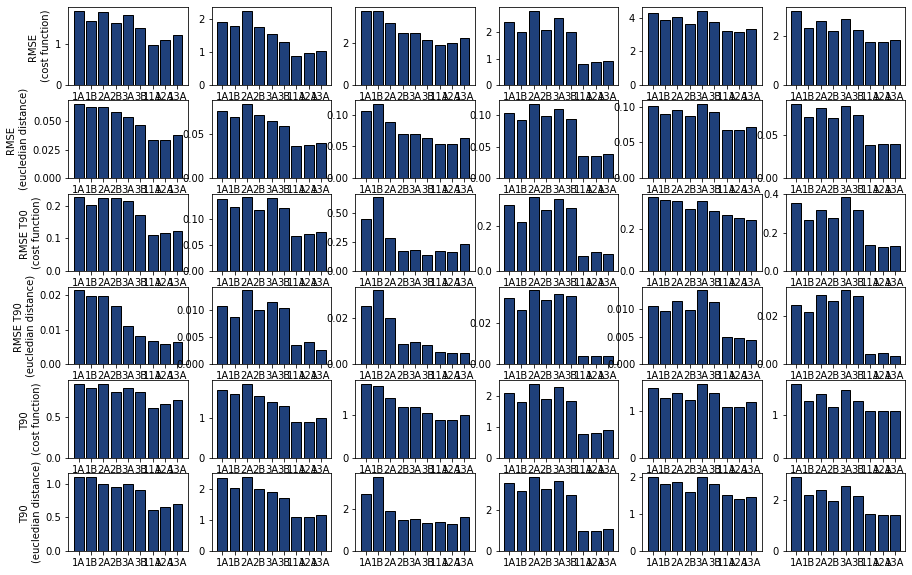

In [210]:
SeqHandlerObject.sequences_barplot(cost_mode='both')

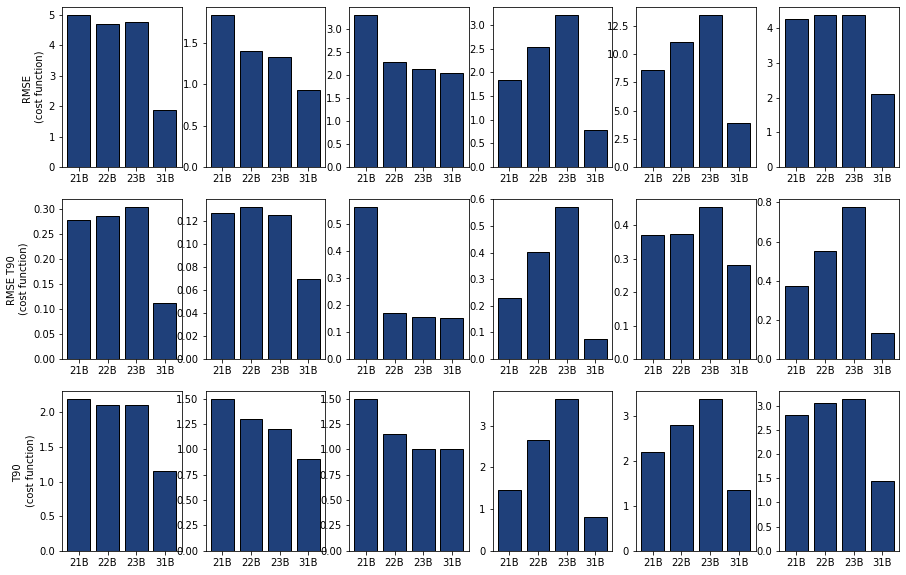

In [206]:
SeqHandlerObject.sequences_barplot(cost_mode='cost')

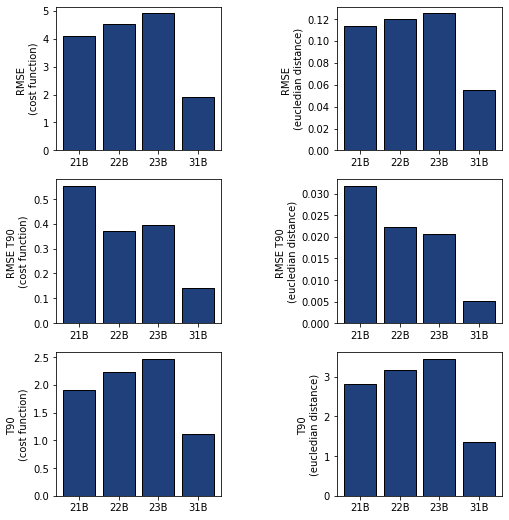

In [207]:
SeqHandlerObject.short_summary_barplot(avg_mode='mean',cost_mode='both')